In [ ]:
!pip install river
!pip install jupyter-dash

In [1]:
import praw
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from IPython import display
from river.linear_model import LinearRegression
from river import stream
from river import metrics
from river import optim
import py4j

from dash import Dash, dcc, html, Input, Output
import dash_bootstrap_components as dbc
from plotly import express as px
import plotly.graph_objects as go

from jupyter_dash import JupyterDash

import requests

In [2]:
py4j.__version__

'0.10.9.5'

In [3]:
import findspark

findspark.find()
findspark.init(spark_home=findspark.find())

Don't forget that the `reddit_producer.py` should be running and listening.

In [4]:
with open("config.json", "r") as jsonfile:
    data = json.load(jsonfile)
    print("Config data read successful", data)

Config data read successful {'client_id': 'pSw3J0Wx8Go88uysRQ09wg', 'client_secret': 'l-7GHTkbRycqcC0ZkRoQAXDvrkKP4A'}


In [5]:
!java -version

java version "19.0.1" 2022-10-18
Java(TM) SE Runtime Environment (build 19.0.1+10-21)
Java HotSpot(TM) 64-Bit Server VM (build 19.0.1+10-21, mixed mode, sharing)


In [6]:
from collections import namedtuple  # Each element will be assigned a field
import sys
from pyspark import SparkContext, SparkConf
from pyspark.streaming import StreamingContext
from pyspark.sql import SparkSession,SQLContext
# Allow us to order things in decscending order
from pyspark.sql.functions import desc



# create spark configuration
conf = SparkConf()
conf.setAppName("RedditStreamApp")
# create spark context with the above configuration
sc = SparkContext(conf=conf)
sc.setLogLevel("ERROR")
# create the Streaming Context from the above spark context with interval size 10 seconds
ssc = StreamingContext(sc, 10)
# setting a checkpoint to allow RDD recovery
# ssc.checkpoint("checkpoint_RedditApp")
# read data from port 5590
# socket_stream = ssc.socketTextStream("localhost", 5590)


# sc = SparkContext() # Establish an entry point of Apache Spark functionality.
# ssc = StreamingContext(sc, 10) # Create streaming context with intervals of 10 seconds.
sqlContext = SQLContext(sc) # Initialising Spark SQL functionalities.

socket_stream = ssc.socketTextStream("127.0.0.1", 5590)


C:\Users\hpapa\anaconda3\envs\pyspark\lib\site-packages\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [7]:
lines = socket_stream.window(20) # 20 second windows of time
fields = ('comment','author', "subreddit", "created_utc")
RedditComment = namedtuple('RedditComment', fields)

In [8]:
def get_sql_context_instance(spark_context):
    if ('sqlContextSingletonInstance' not in globals()):
        globals()['sqlContextSingletonInstance'] = SQLContext(spark_context)
    return globals()['sqlContextSingletonInstance']


def test_content(string):
#     print(string)
    return eval(string)


def process_rdd(time, rdd):
    # print("----------- %s -----------" % str(time))
    try:
        # Get spark sql singleton context from the current context
        sql_context = get_sql_context_instance(rdd.context)

        row_rdd = rdd.map(lambda rec: RedditComment(rec['comment'],rec['author'], rec["subreddit"], rec["created_utc"]))
        comments_df = sql_context.createDataFrame(row_rdd)
        comments_df.registerTempTable("comments")

    except:
        e = sys.exc_info()[0]
        print("Error: %s" % e)



(lines.map(lambda text: test_content(text))
    .foreachRDD(process_rdd)
    )

In [9]:
# function that returns the number of unique words in a given string
def unique_nb_words(string):
    words = []
    
    string = string.replace("[^\w\s]", "")
    string = string.split(" ")
    
    for word in string:
        if word not in words:
            words.append(word)
        else:
            continue
            
    return len(words)

<span style="color:red">MUST LET THIS RUN UNTIL AT LEAST ONE WARNING SHOWS UP BEFORE RUNNING NEXT CELLS, OTHERWISE ERROR WILL SHOW IN NEXT CELLS</span>

In [10]:
ssc.start()
# ssc.awaitTermination()  

C:\Users\hpapa\anaconda3\envs\pyspark\lib\site-packages\pyspark\sql\dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


### Print the timestamps of the comments as they arrive on the Spark streaming resource

In [11]:
# just running it 5 times to show that it works
i = 0
while i < 5:
    data = sqlContext.sql("SELECT created_utc FROM comments").toPandas()
    print(data)
    i += 1
    time.sleep(10)

             created_utc
0    2022-12-16 16:19:08
1    2022-12-16 16:19:08
2    2022-12-16 16:19:10
3    2022-12-16 16:19:15
4    2022-12-16 16:19:21
..                   ...
96   2022-12-16 16:25:38
97   2022-12-16 16:25:41
98   2022-12-16 16:25:43
99   2022-12-16 16:25:44
100  2022-12-16 16:25:49

[101 rows x 1 columns]


C:\Users\hpapa\anaconda3\envs\pyspark\lib\site-packages\pyspark\sql\dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


           created_utc
0  2022-12-16 16:25:50
1  2022-12-16 16:25:55
2  2022-12-16 16:26:01
3  2022-12-16 16:26:04
4  2022-12-16 16:26:04
5  2022-12-16 16:26:08


C:\Users\hpapa\anaconda3\envs\pyspark\lib\site-packages\pyspark\sql\dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


           created_utc
0  2022-12-16 16:26:21
1  2022-12-16 16:26:27


C:\Users\hpapa\anaconda3\envs\pyspark\lib\site-packages\pyspark\sql\dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


           created_utc
0  2022-12-16 16:26:21
1  2022-12-16 16:26:27
2  2022-12-16 16:26:31


C:\Users\hpapa\anaconda3\envs\pyspark\lib\site-packages\pyspark\sql\dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


           created_utc
0  2022-12-16 16:26:47
1  2022-12-16 16:26:52
2  2022-12-16 16:26:55


C:\Users\hpapa\anaconda3\envs\pyspark\lib\site-packages\pyspark\sql\dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


### Average number of unique words per comment updated every 10 secs

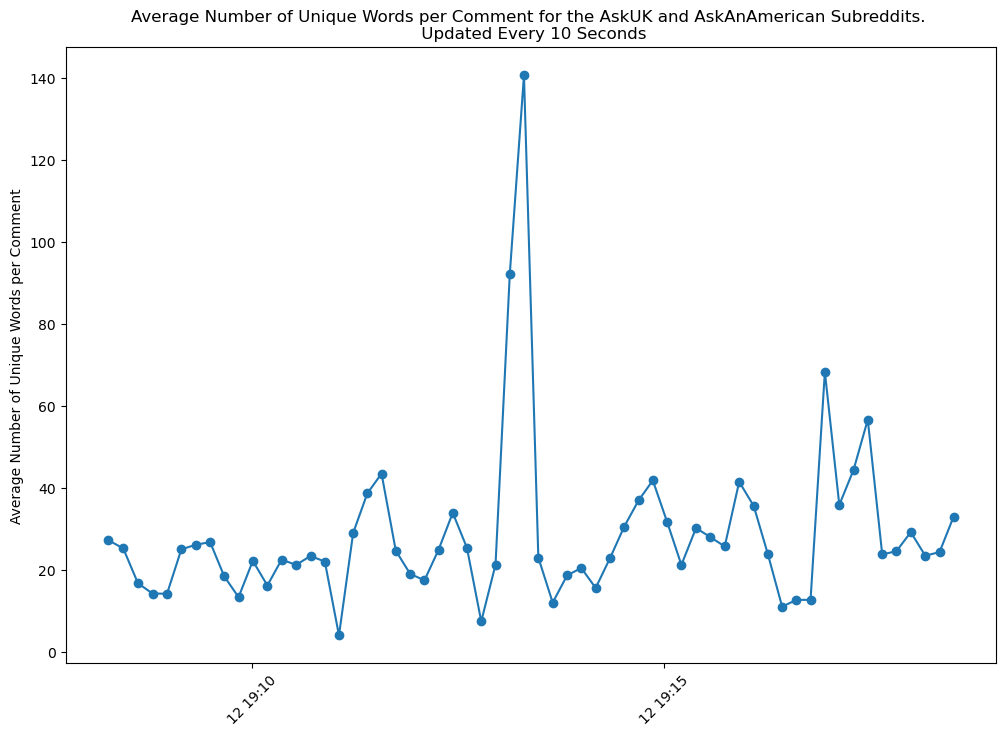

Error: <class 'ValueError'>


In [12]:
# empty lists to which we will append the mean number of unique words per comment and the collected datetime
average_nb = []
dt = []

i = 0

# run it for 10 minutes (600 seconds in ten minutes, so run this loop 60 times)
# just running it 5 times to show that it works
while i < 60:
    data = sqlContext.sql("SELECT created_utc, comment FROM comments").toPandas()
    
    # create a column which will contain the number of unique words in the comment column
    data["unique"] = data["comment"].apply(unique_nb_words)
    
    # append the mean of this column to our list
    average_nb.append(np.mean(data["unique"]))
    
    # append the collected datetime
    dt.append(datetime.now())
    
    # clear the previous graph from the screen
    display.clear_output(wait = True)
    
    # plot the average number of unique words per comment
    fig, ax = plt.subplots(figsize = (12, 8))
    plt.scatter(dt, average_nb)
    plt.plot(dt, average_nb)
    ax = plt.gca()
    plt.setp(ax.get_xticklabels(), rotation=45)
    plt.ylabel("Average Number of Unique Words per Comment")
    plt.title("Average Number of Unique Words per Comment for the AskUK and AskAnAmerican Subreddits. \n Updated Every 10 Seconds", fontsize = 12)
    plt.show()
    i += 1
    
    # update it every 10 seconds
    time.sleep(10)

### Cumulative number of unique words per comment updated every 10 secs. Separated by subreddit (AskUK and AskAnAmerican)

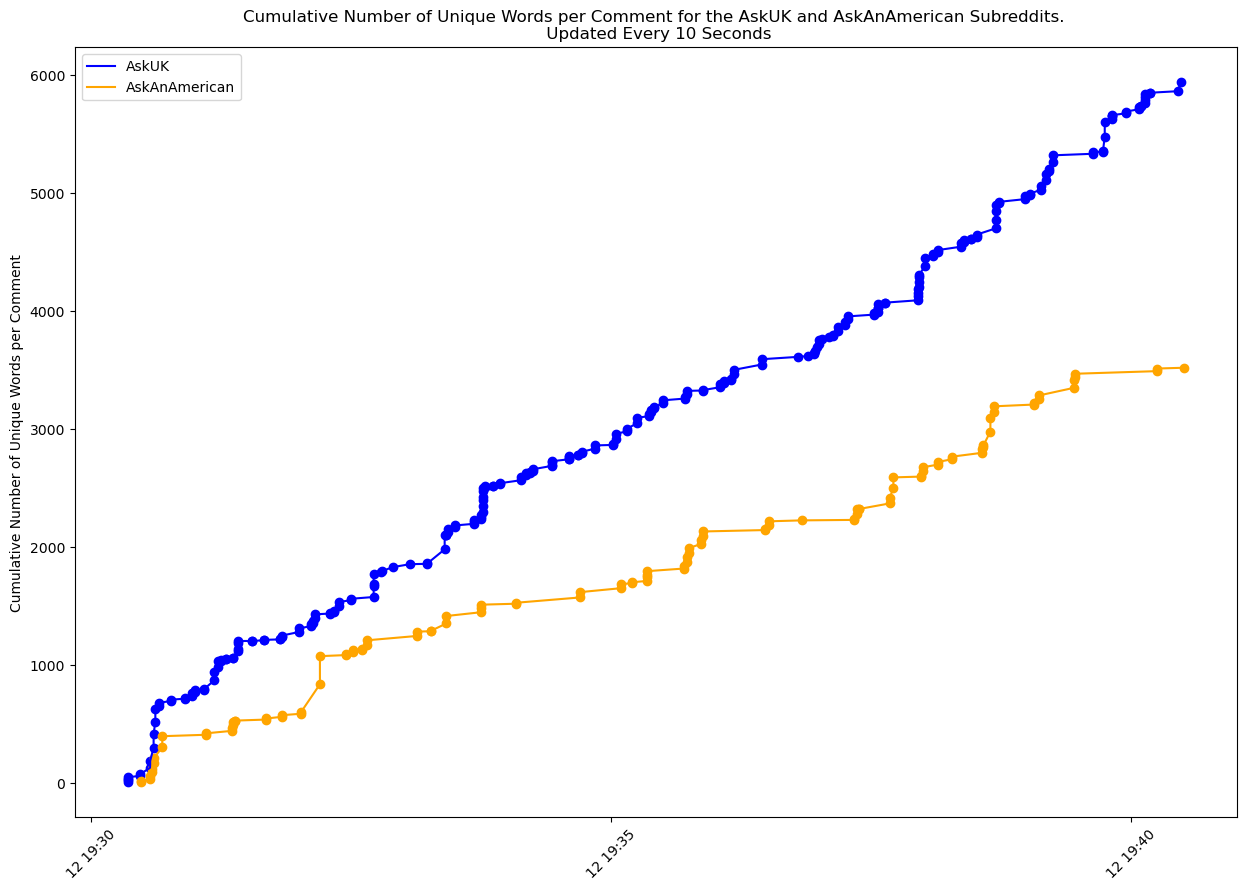

/Users/anneliserhodes/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [15]:
# create our empty lists to which we will append the number of unique words per comment and their associated created_utc
uk_nb = []
uk_dt = []

us_nb = []
us_dt = []

i = 0

# running it for 10 minutes
while i < 60:
    
    # clear the previous graph from the screen
    display.clear_output(wait = True)
    
    data = sqlContext.sql("SELECT created_utc, comment, subreddit FROM comments").toPandas()
    
    # create a column which will contain the number of unique words in the comment column
    data["unique"] = data["comment"].apply(unique_nb_words)
    
    # split the dataset into two datasets, one for the AskUK subreddit and one for the AskAnAmerican subreddit
    uk_data = data[data["subreddit"] == "AskUK"]
    us_data = data[data["subreddit"] == "AskAnAmerican"]
    
    # append the number of unique words per comment and their associated created_utc to the lists created outside the loop
    uk_nb.append(uk_data["unique"].values)
    uk_dt.append(uk_data["created_utc"].values)
    
    us_nb.append(us_data["unique"].values)
    us_dt.append(us_data["created_utc"].values)
    
    # the lists outside the list are lists composed of arrays, so we need to flatten those into a single list
    uk_un = [item for sublist in uk_nb for item in sublist]
    uk_d = [item for sublist in uk_dt for item in sublist]
    
    us_un = [item for sublist in us_nb for item in sublist]
    us_d = [item for sublist in us_dt for item in sublist]
    
    # create new dataframes containing two columns: the amount of unique words per comment and their created_utc
    new_uk = pd.DataFrame({"unique": uk_un, "dates": uk_d})
    new_uk['dates'] = pd.to_datetime(new_uk['dates'], format="%Y-%m-%d %H:%M:%S")
    
    new_us = pd.DataFrame({"unique": us_un, "dates": us_d})
    new_us['dates'] = pd.to_datetime(new_us['dates'], format="%Y-%m-%d %H:%M:%S")
    
    new_uk.sort_values("dates", inplace = True) 
    new_us.sort_values("dates", inplace = True)
    
    # plot the cumulative number of unique words per comment
    fig,ax = plt.subplots(figsize = (15, 10))
    plt.scatter(new_uk["dates"], np.cumsum(new_uk["unique"]), color = "blue")
    plt.plot(new_uk["dates"], np.cumsum(new_uk["unique"]), color = "blue", label = "AskUK")
    
    plt.scatter(new_us["dates"], np.cumsum(new_us["unique"]), color = "orange")
    plt.plot(new_us["dates"], np.cumsum(new_us["unique"]), color = "orange", label = "AskAnAmerican")
    
    ax = plt.gca()
    plt.setp(ax.get_xticklabels(), rotation=45)
    plt.ylabel("Cumulative Number of Unique Words per Comment")
    plt.legend()
    plt.title("Cumulative Number of Unique Words per Comment for the AskUK and AskAnAmerican Subreddits. \n Updated Every 10 Seconds", fontsize = 12)
    plt.show()
    i += 1
    
    # update it every 10 seconds
    time.sleep(10)

This plot was obtained after running the above code for 10 minutes. Firstly, we can see that in that time period, there were a lot more comments posted on the AskUK subreddit than on the AskAnAmerican subreddit. This data was collected at 19:30pm UTC+1, therefore people in the US might still be at work whereas people in the UK are coming out of school or have just finished work and might therefore be more active on social media, explaining the lower number of comments in the AskAnAmerican subreddit. 

Furthermore, comments on both subreddits seem to contain approximately the same amount of unique words on average. This would seem to indicate that there is not much difference in the amount of unique words per comment for each subreddit.

### River Linear Regression

ITERATION 10 

TRUE Y: 0      9
1     61
2     16
3    100
4     35
5     30
Name: number of words, dtype: int64

PREDICTED Y: 0    11.765782
1    67.916232
2    18.294904
3    97.950194
4    41.799744
5    35.270622
Name: number of words, dtype: float64

SLOPE: 1.285063487673
INTERCEPT: 0.01262922710380337
MSE: 0    2121.882557
1      63.815345
2    1377.804786
3     226.892535
4            NaN
5            NaN
dtype: float64


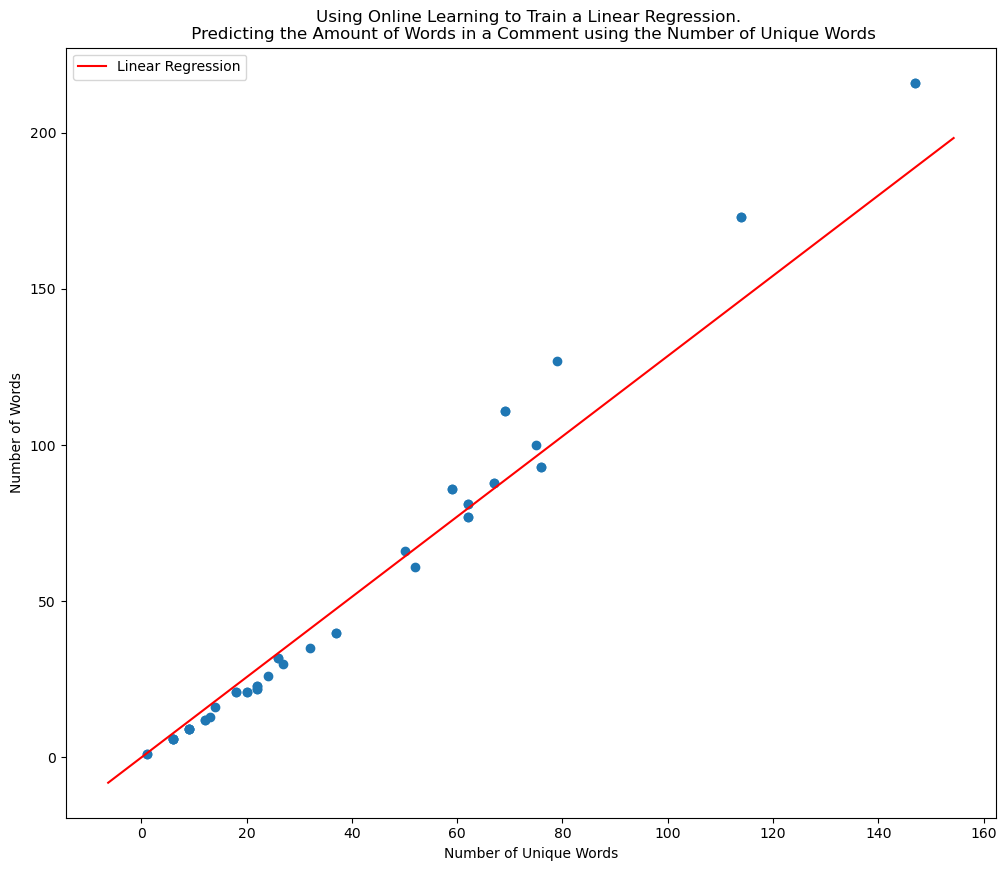

/Users/anneliserhodes/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [11]:
# returns the amount of words in a string
def number_of_words(string):
    return len(string.split(" "))

# initialise our optimizer object, we will use Stochastic Gradient Descent with a learning rate of 0.0001
optimizer = optim.SGD(0.0001)

# initialise our Linear Regression object using Stochastic Gradient Descent and an intercept learning rate of 0.0001
linear_reg = LinearRegression(intercept_lr = 0.0001, optimizer = optimizer)

# initialise our metrics object, we will use the Mean Squared Error to determine the performance of our model
metric = metrics.MSE()


# for plotting purposes
d = []
tar = []

# Just run it 10 times to show it works
i = 0
while i < 10:
    # Clear the previous graph
    display.clear_output(wait = True)
    
    data = sqlContext.sql("SELECT comment FROM comments").toPandas()
    
    # Create a column containg the unique number of words in the comment column
    data["unique"] = data["comment"].apply(unique_nb_words)
    # Create a column containg the number of words in the comment column
    data["number of words"] = data["comment"].apply(number_of_words)
    
    # for plotting purposes
    for number in data["unique"]:
        d.append(number)
    for number in data["number of words"]:
        tar.append(number)

    # input feature
    X = data.drop(["comment", "number of words"], axis = 1)
    # target variable
    y = data.pop("number of words")
    
    # predict the yis
    y_pred = linear_reg.predict_many(X)
    linear_reg.learn_many(X, y)
    # update the metric object
    metric.update(y, y_pred)
    
    # retrieve the weights
    weights = linear_reg.weights
    
    slope = weights["unique"]
    intercept = linear_reg.intercept
    
    print(f"ITERATION {i+1} \n")
    print("TRUE Y: " + str(y) + "\n")
    print("PREDICTED Y: " + str(y_pred) + "\n")
    print("SLOPE: "+ str(slope))
    print("INTERCEPT: " + str(intercept))
    print("MSE: " + str(metric.get()))
    
    # plot our linear regression, updated every 10 seconds
    fig, ax = plt.subplots(figsize = (12, 10))
    plt.scatter(d, tar)
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, color = "red", label = "Linear Regression")
    plt.xlabel("Number of Unique Words")
    plt.ylabel("Number of Words")
    plt.legend(loc = "upper left")
    plt.title("Using Online Learning to Train a Linear Regression. \n Predicting the Amount of Words in a Comment using "
              +"the Number of Unique Words", fontsize = 12)
    
    plt.show()
    i+= 1
    
    # update it every 10 seconds
    time.sleep(10)

The plot shows that the relationship between number of unique words in a comment and number of words in the comment is linear with some noise. Indeed, the Linear Regression performs quite well for comments with a small amount of unique numbers. However the data somewhat deviates from the best fitting line, especially at the upper tail. However, this is most likely due to not running our model for long enough. We only trained our model over 10 iterations; our model only saw 10 batches of data. If we were to train our model for longer we would observe better results because as mentioned previously, the relationship between number of unique words per comment and total number of words per comment seems to be linear, therefore not too complicated to be captured by a simple Linear Regression. 

### Interactive plots for previous two tasks

For both of these you need to change the port if you want to run it again.

#### Cumulative Number of Unique Words per Comment

In [ ]:
uk_nb = []
uk_dt = []

us_nb = []
us_dt = []

i = 0

app = JupyterDash()

app.layout = html.Div(
    [
        html.H4("Cumulative Sum of Unique Words per Comment for Both Subreddits"),
        dcc.Graph(id = "unique words cum"),
        dcc.Interval(id = "interval", interval = 10000) # INTERVAL ARGUMENT THIS SHOULD GET IT TO UPDATE 
                                                        # EVERY 10 SECONDS HOWEVER IT DOES SO MORE OR LESS
    ]
)

@app.callback(
    Output("unique words cum", "figure"),
    Input("interval", "n_intervals")
)
def update_figure(n_intervals):
    
    data = sqlContext.sql("SELECT created_utc, comment, subreddit FROM comments").toPandas()
    
    # create a column which will contain the number of unique words in the comment column
    data["Unique Number of Words"] = data["comment"].apply(unique_nb_words)
    
    # split the dataset into two datasets, one for the AskUK subreddit and one for the AskAnAmerican subreddit
    uk_data = data[data["subreddit"] == "AskUK"]
    us_data = data[data["subreddit"] == "AskAnAmerican"]
    
    # append the number of unique words per comment and their associated created_utc to the lists created outside the loop
    uk_nb.append(uk_data["Unique Number of Words"].values)
    uk_dt.append(uk_data["created_utc"].values)
    
    us_nb.append(us_data["Unique Number of Words"].values)
    us_dt.append(us_data["created_utc"].values)
    
    # the lists outside the list are lists composed of arrays, so we need to flatten those into a single list
    uk_un = [item for sublist in uk_nb for item in sublist]
    uk_d = [item for sublist in uk_dt for item in sublist]
    
    us_un = [item for sublist in us_nb for item in sublist]
    us_d = [item for sublist in us_dt for item in sublist]
    
    # create new dataframes containing two columns: the amount of unique words per comment and their created_utc
    new_uk = pd.DataFrame({"Unique Number of Words": uk_un, "Time": uk_d})
    new_uk['Time'] = pd.to_datetime(new_uk['Time'], format="%Y-%m-%d %H:%M:%S")
    
    new_us = pd.DataFrame({"Unique Number of Words": us_un, "Time": us_d})
    new_us['Time'] = pd.to_datetime(new_us['Time'], format="%Y-%m-%d %H:%M:%S")
    
    new_uk.sort_values("Time", inplace = True) 
    new_us.sort_values("Time", inplace = True)
    
    new_uk["subreddit"] = "AskUK"
    new_us["subreddit"] = "AskAnAmerican"
    
    new_uk["Cumulative Sum of Unique Words per Comment"] = np.cumsum(new_uk["Unique Number of Words"])
    new_us["Cumulative Sum of Unique Words per Comment"] = np.cumsum(new_us["Unique Number of Words"])
    
    df = new_uk.append(new_us)
    
    fig = px.line(df, x = df["Time"], y = df["Cumulative Sum of Unique Words per Comment"], color = "subreddit")
    
    return fig
    
    

app.run_server(mode = "jupyterlab", debug=False, port = 8161)

#### River Linear Regression

In [ ]:
# returns the amount of words in a string
def number_of_words(string):
    return len(string.split(" "))

# initialise our optimizer object, we will use Stochastic Gradient Descent with a learning rate of 0.0001
optimizer = optim.SGD(0.0001)

# initialise our Linear Regression object using Stochastic Gradient Descent and an intercept learning rate of 0.0001
linear_reg = LinearRegression(intercept_lr = 0.0001, optimizer = optimizer)

# initialise our metrics object, we will use the Mean Squared Error to determine the performance of our model
metric = metrics.MSE()


# for plotting purposes
d = []
tar = []

app = JupyterDash()

app.layout = html.Div(
    [
        html.H4("Online Learning Linear Regression using River"),
        dcc.Graph(id = "LinReg"),
        dcc.Interval(id = "interval", interval = 10000) # INTERVAL ARGUMENT THIS SHOULD GET IT TO UPDATE 
                                                        # EVERY 10 SECONDS HOWEVER IT DOES SO MORE OR LESS
    ]
)

@app.callback(
    Output("LinReg", "figure"),
    Input("interval", "n_intervals")
)

def update_figure(n_intervals):
    
    data = sqlContext.sql("SELECT comment FROM comments").toPandas()
    
    # Create a column containg the unique number of words in the comment column
    data["Unique Number of Words"] = data["comment"].apply(unique_nb_words)
    # Create a column containg the number of words in the comment column
    data["Number of Words"] = data["comment"].apply(number_of_words)
    
    # for plotting purposes
    for number in data["Unique Number of Words"]:
        d.append(number)
    for number in data["Number of Words"]:
        tar.append(number)

    # input feature
    X = data.drop(["comment", "Number of Words"], axis = 1)
    # target variable
    y = data.pop("Number of Words")
    
    # predict the yis
    y_pred = linear_reg.predict_many(X)
    linear_reg.learn_many(X, y)
    # update the metric object
    metric.update(y, y_pred)
    
    # retrieve the weights
    weights = linear_reg.weights
    
    slope = weights["Unique Number of Words"]
    intercept = linear_reg.intercept
    
    x_vals = np.arange(start = 0, stop = max(d) + 2, step = 0.01)
    y_vals = x_vals * slope + intercept
    line_plot = pd.DataFrame({"x": x_vals, "y":y_vals})
    
    data["Number of Words"] = y
    
    df = data.copy()
    
    print(df)
    print(df["Unique Number of Words"])
    print(df["Number of Words"])
    print(df.dtypes)
    
    
    fig = px.scatter(data, x = data["Unique Number of Words"], y = data["Number of Words"], color_discrete_sequence=['red'])
    fig.add_traces(px.line(line_plot, x_vals, y_vals).data)
    
    print(fig)
    return fig

app.run_server(mode = "jupyterlab", debug=False, port = 8159)

In [ ]:
ssc.stop()